# **Take-Home Challenge: Genomic Text Curation & Topic Grouping**
*YuHsuan Huang*


# Part1: Introduction

This project establishes a robust Natural Language Processing (NLP) pipeline designed to extract structured, curatable knowledge from a collection of unstructured genomic abstracts and to categorize these documents by topic.

# Part2: Environment Setup & Data Integrity

## 2.1 Environment Setup & Library Installation

This section prepares the necessary libraries and NLP models for the text curation pipeline. It ensures compatible versions of spacy, pandas, and numpy are installed and loads the standard English spaCy model for subsequent processing, such as entity extraction and tokenization.

In [ ]:
# Install core NLP and data processing libraries
!pip install -q spacy==3.7.4 pandas==2.2.2 numpy==1.26.4

# Install the exact compatible version of the spaCy English model
!pip install -q https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1.tar.gz

import spacy
import pandas as pd
import numpy as np
import re
import os
import json
from dataclasses import dataclass, asdict
from typing import List, Dict, Any, Optional
from collections import defaultdict

nlp = spacy.load("en_core_web_sm")

# Create output directory for saving results
os.makedirs("outputs", exist_ok=True)

print("Environment ready.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 124.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Environment ready.


## 2.2 Loading texts.csv

Loads texts.csv, performs column validation, checks for missing/duplicate data, and calculates basic text statistics.

In [ ]:
# Mount Google Drive to the specified path in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the file path
texts_path = '/content/drive/MyDrive/texts.csv'

In [ ]:
# Read the crime data from the specified path.
texts = pd.read_csv(texts_path)
texts.columns = ['id', 'text']

# Display the first 5 rows of the DataFrame.
texts.head(5)

,id,text
0,1,The International Genomics of Alzheimer's Proj...
1,2,Alzheimer's disease (AD) is a progressive neur...
2,3,The risk of APOE for Alzheimer's disease (AD) ...
3,4,Risk for late-onset Alzheimer's disease (LOAD)...
4,5,Alzheimer's disease (AD) is highly heritable a...


## 2.3 Data Quality Check

In [ ]:
# display the basic info
display(texts.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      70 non-null     int64 
 1   text    70 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


None

In [ ]:
# display the missing values
display(texts.isna().sum())

,0
id,0
text,0


In [ ]:
# display the text length statistics
texts["text_length"] = texts["text"].astype(str).str.len()
display(texts["text_length"].describe(percentiles=[0.1, 0.5, 0.9, 0.95, 0.99]))

,text_length
count,70.000000
mean,1550.657143
std,533.331365
min,658.000000
10%,1011.900000
50%,1428.500000
90%,2182.500000
95%,2614.400000
99%,2952.250000
max,3073.000000


# Part3: Hybrid Genomic Entity Extraction (NER)

## 3.1 Rule-based Extractors

It sets up regular expression patterns and corresponding functions to identify two specific types of genomic entities with high precision: Variant IDs and candidate Gene Symbols.

In [ ]:
# Regex pattern for rsID variants (e.g., rs12345, rs3099999)
RSID_PATTERN = r"\brs[0-9]{3,}\b"
# Simple heuristic: 3 to 10 character long, fully uppercase alphanumeric token
GENE_PATTERN = r"\b[A-Z0-9]{3,10}\b"


def extract_rsid(texts):
    # Find all occurrences of the rsID pattern
    return re.findall(RSID_PATTERN, texts)


def extract_genes(texts):
    """Extract candidate gene symbols by uppercase token rule."""
    # Find all tokens matching the simple uppercase heuristic
    tokens = re.findall(GENE_PATTERN, texts)
    # Define a small list of unwanted common tokens (noise filtering)
    blacklist = {"DNA", "RNA", "USA", "COVID", "COVID19", "GWAS"}
    # Filter out common abbreviations that are likely not gene symbols
    return [t for t in tokens if t not in blacklist]

## 3.2 Model-based Extractors

It focuses on identifying Disease and Phenotype entities using the pre-trained spaCy Named Entity Recognition model.

In [ ]:
def extract_spacy_entities(doc):
    """Extract spaCy NER entities (Disease, Phenotype)."""
    disease_like = []

    for ent in doc.ents:
        # If using a biomedical model (e.g., SciSpaCy), use specific labels
        if ent.label_ in ["DISEASE", "DIS", "ILLNESS", "SYMPTOM"]:
            disease_like.append(ent.text)

        # The small model often misclassifies biological entities as ORG/GPE/NORP.
        if ent.label_ in ["ORG", "GPE", "NORP"] and any(x in ent.text.lower() for x in ["disease", "syndrome", "alzheimer", "dementia"]):
            disease_like.append(ent.text)

    # Return unique disease/phenotype terms
    return sorted(list(set(disease_like)))

## 3.3 Structured Schema Builder

This goal is to orchestrate the extraction process and consolidate the findings into a structured, machine-readable schema for easy curation and downstream analysis.

In [ ]:
def build_schema(text_id, text):
    # Process the text using the loaded spaCy NLP model
    doc = nlp(text)

    # Rule-based extraction
    variants = extract_rsid(text)
    genes = extract_genes(text)

    # Model-based extraction
    diseases = extract_spacy_entities(doc)

    # Return the structured result as a dictionary
    return {
        "id": text_id,
        "variants": sorted(list(set(variants))), # Ensure uniqueness and sort for consistency
        "genes": sorted(list(set(genes))),
        "diseases": sorted(list(set(diseases))),
        "raw_text": text
    }

## 3.4 Apply Hybrid Extraction to Entire Dataset

This section iterates through every document in the input texts and applies the build_schema function, which combines rule-based and model-based extraction methods. The goal is to generate a comprehensive, structured record for each text, capturing the extracted Variants, Genes, and Diseases.

The resulting list of structured dictionaries is then saved to a JSON file (outputs/section2_hybrid_schema.json).

In [ ]:
structured_results = []

# Iterate through each row of the cleaned DataFrame
for i, row in texts.iterrows():
    text_id = row["id"]
    # Ensure text is clean (assuming clean_text() handles basic prep from Section 1)
    text = row["text"]

    # Build the structured schema for the current text
    schema = build_schema(text_id, text)
    structured_results.append(schema)

# Save the structured schema results to a JSON file
with open("outputs/section2_hybrid_schema.json", "w") as f:
    json.dump(structured_results, f, indent=2)

print("Section 2 hybrid extraction completed.")
print(f"Processed texts: {len(structured_results)}")

# Convert results back to a DataFrame for easier manipulation in Section 3/4
df_curated = pd.DataFrame(structured_results)

Section 2 hybrid extraction completed.
Processed texts: 70


## 3.5 Extraction Performance & Quality Analysis

Since manual verification is time-consuming, this analysis uses simple rules to estimate the scale of potential extraction errors, helping to identify which entity extraction methods need the most improvement.

In [ ]:
def error_analysis(structured):

    stats = defaultdict(int)

    for row in structured:
        v = row["variants"]
        g = row["genes"]
        d = row["diseases"]

        # Count documents where no entity of a certain type was found
        if len(v) == 0:
            stats["variant_fn_count"] += 1
        if len(g) == 0:
            stats["gene_fn_count"] += 1
        if len(d) == 0:
            stats["disease_fn_count"] += 1

        # The simple uppercase rule is prone to FPs
        for gene in g:
            # Short uppercase tokens are often general abbreviations
            if len(gene) <= 3:
                stats["gene_fp_short_count"] += 1
            # Fully numeric uppercase tokens are impossible for standard gene symbols
            if gene.isdigit():
                stats["gene_fp_numeric_count"] += 1
            # Note: More robust FP detection would require external dictionaries or contextual checks.

    return stats


analysis = error_analysis(structured_results)

# Save the error analysis report
with open("outputs/section2_error_analysis.json", "w") as f:
    json.dump(analysis, f, indent=2)

print("Error analysis completed.")
# Display the analysis results
analysis

Error analysis completed.


defaultdict(int,
            {'variant_fn_count': 35,
             'gene_fp_short_count': 287,
             'disease_fn_count': 49,
             'gene_fp_numeric_count': 226})

# Part4: Relation Triplet Construction & Linking

## 4.1 Relation Keyword & Span Helper Functions

It sets up the rules for inferring the relationship between entities and localizing the supporting text.

In [ ]:
# Load structured entities from the previous section's output
with open("outputs/section2_hybrid_schema.json", "r") as f:
    structured = json.load(f)

In [ ]:
# List of keywords representing genetic association or effect
RELATION_KEYWORDS = [
    "associated with",
    "increases risk of",
    "linked to",
    "related to",
    "affects",
    "causes",
    "reduces",
    "protective for"
]

def find_relation_phrase(text):
    """Return the first matched relation keyword in text."""
    t = text.lower()
    for kw in RELATION_KEYWORDS:
        # Check if the keyword exists in the text
        if kw in t:
            return kw
    return "associated with"    # Default baseline relation if no keyword is found

In [ ]:
def get_evidence_span(text, variant, gene, phenotype):
    """Return the smallest sentence containing all three entities (Variant, Gene, Phenotype)."""
    # Process the text using spaCy for sentence boundary detection
    doc = nlp(text)

    # Iterate over each sentence in the document
    for sent in doc.sents:
        s = sent.text
        # Check if all three entities exist in the current sentence
        if (variant in s) and (gene in s) and (phenotype in s):
            return s
    # Fallback: if no single sentence contains all three, return the full text
    return text

## 4.2 Structured Output Logic

This function is to transform the lists of entities extracted from each document into specific, actionable Genomic Triplet Relations

In [ ]:
final_relations = []

# Iterate through each document's entity extraction results
for entry in structured:
    tid = entry["id"]
    text = entry["raw_text"]

    variants = entry["variants"]
    genes = entry["genes"]
    phenotypes = entry["diseases"]

    # Only create full triplets (variant, gene, disease)
    # Perform a Cartesian product of all extracted entities in the document
    for v in variants:
        for g in genes:
            for p in phenotypes:

                # 1. Determine the Relation keyword
                relation = find_relation_phrase(text)
                # 2. Find the minimal Evidence Span (sentence containing all 3)
                evidence = get_evidence_span(text, v, g, p)

                # Append the final structured triplet to the results list
                final_relations.append({
                    "text_id": tid,
                    "variant": v,
                    "gene": g,
                    "phenotype": p,
                    "relation": relation,
                    "evidence_span": evidence # The sentence or text providing context
                })

## 4.3 Results Serialization

In [ ]:
# Save the final results in the assignment's required JSON format
with open("outputs/section3_assignment_relations.json", "w") as f:
    json.dump(final_relations, f, indent=2)

print("Final assignment-style relation extraction completed.")
print(f"Total records (triplets): {len(final_relations)}")

Final assignment-style relation extraction completed.
Total records (triplets): 418


# Part5: Topic Modeling and Clustering

## 5.1 Environment Setup & Library Installation

In [ ]:
# Install required libraries for embeddings, dimensionality reduction, and clustering
!pip install -q sentence-transformers umap-learn scikit-learn

import os
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import umap

os.makedirs("outputs", exist_ok=True)

## 5.2 Data Loading

This initial block ensures all required libraries for embedding and clustering are installed, and loads the necessary structured entity data into a DataFrame for downstream processing. It also conditionally loads and merges the relation statistics.

In [ ]:
# Load structured entities from Section 2
with open("outputs/section2_hybrid_schema.json", "r") as f:
    sec2 = json.load(f)

df_topics = pd.DataFrame(sec2)
df_topics["id"] = df_topics["id"].astype(str)

# Robustness check: Ensure all required list columns exist and handle NaNs
for col in ["variants", "genes", "diseases"]:
    if col not in df_topics.columns:
        df_topics[col] = [[] for _ in range(len(df_topics))]
    else:
        df_topics[col] = df_topics[col].apply(lambda x: x if isinstance(x, list) else [])

print("Section 2 records:", len(df_topics))

Section 2 records: 70


In [ ]:
relations_path = "outputs/section3_assignment_relations.json"

if os.path.exists(relations_path):
    with open(relations_path, "r") as f:
        sec3 = json.load(f)
    df_rel = pd.DataFrame(sec3)
    df_rel["text_id"] = df_rel["text_id"].astype(str)

    rel_agg = (
        df_rel.groupby("text_id")
        .agg(
            relation_count=("relation", "count"),
            relation_types=("relation", lambda x: sorted(set(x))),
        )
        .reset_index()
        .rename(columns={"text_id": "id"})
    )

    df_topics = df_topics.merge(rel_agg, on="id", how="left")
    df_topics["relation_count"] = df_topics["relation_count"].fillna(0).astype(int)
    df_topics["relation_types"] = df_topics["relation_types"].apply(
        lambda x: x if isinstance(x, list) else []
    )
    df_topics["has_relation"] = df_topics["relation_count"] > 0
else:
    df_topics["relation_count"] = 0
    df_topics["relation_types"] = [[] for _ in range(len(df_topics))]
    df_topics["has_relation"] = False

print("Merged with Section 3. Rows:", len(df_topics))
display(df_topics.head())

Merged with Section 3. Rows: 70


,id,variants,genes,diseases,raw_text,relation_count,relation_types,has_relation
0,1,[],"[ABCA7, CD2AP, CD33, CELF1, DLGAP1, DSG2, IGAP...",[The International Genomics of Alzheimer's],The International Genomics of Alzheimer's Proj...,0,[],False
1,2,[],[FDR],[],Alzheimer's disease (AD) is a progressive neur...,0,[],False
2,3,[],"[6559, 895, APOE, BIN1, MS4A4E, OR2S2, PICALM]",[Disease Genetics Consortium],The risk of APOE for Alzheimer's disease (AD) ...,0,[],False
3,4,[],"[437, ACE, ADAM10, ADAMTS1, APP, DR15, HLA, IQ...",[],Risk for late-onset Alzheimer's disease (LOAD)...,0,[],False
4,5,[],"[215, 378, 383, 880]",[],Alzheimer's disease (AD) is highly heritable a...,0,[],False


In [ ]:
df_topics["variant_count"] = df_topics["variants"].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_topics["gene_count"] = df_topics["genes"].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_topics["disease_count"] = df_topics["diseases"].apply(lambda x: len(x) if isinstance(x, list) else 0)


## 5.3 Build Augmented Text for Topic Modeling

The goal is to enhance the semantic quality of the document by appending the extracted entities and relations directly to the raw text. This ensures that the downstream embedding model (Sentence-BERT) places a higher weight on these crucial, domain-specific keywords, leading to more meaningful clustering .

In [ ]:
def list_to_str(lst):
    # Converts a list of entities/relations into a single space-separated string
    if not lst:
        return ""
    return " ".join(str(x) for x in lst)

def build_aug_text(row):
    """Generates a text string augmented with extracted entities."""
    base = str(row["raw_text"])

    # Extract entity/relation strings
    var_str = list_to_str(row.get("variants", []))
    gene_str = list_to_str(row.get("genes", []))
    dis_str = list_to_str(row.get("diseases", []))
    rel_types = row.get("relation_types", [])
    rel_str = list_to_str(rel_types) if isinstance(rel_types, list) else ""

    parts = [base]

    # Append entities and relations to the base text with a clear prefix (e.g., "VARIANTS:")
    if var_str:
        parts.append(" VARIANTS: " + var_str)
    if gene_str:
        parts.append(" GENES: " + gene_str)
    if dis_str:
        parts.append(" DISEASES: " + dis_str)

    if rel_str:
        parts.append(" RELATIONS: " + rel_str)
    else:
        parts.append(" RELATIONS: none")

    return " ".join(parts)

df_topics["aug_text"] = df_topics.apply(build_aug_text, axis=1)

print("Example augmented text:")
print(df_topics["aug_text"].iloc[0][:500])

Example augmented text:
The International Genomics of Alzheimer's Project (IGAP) is a consortium for characterizing the genetic landscape of Alzheimer's disease (AD). The identified and/or confirmed 19 single-nucleotide polymorphisms (SNPs) associated with AD are located on non-coding DNA regions, and their functional impacts on AD are as yet poorly understood. We evaluated the roles of the IGAP SNPs by integrating data from many resources, based on whether the IGAP SNP was (1) a proxy for a coding SNP or (2) associate


## 5.4 Sentence-BERT Embedding

This crucial step converts the processed and augmented textual data into dense, high-dimensional numerical vectors. Using the Sentence-BERT framework with the all-mpnet-base-v2 model ensures that the resulting vectors capture the semantic meaning of the text.

In [ ]:
# Load a state-of-the-art sentence embedding model
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

# Encode the augmented text into high-dimensional vectors
embeddings = model.encode(
    df_topics["aug_text"].tolist(),
    show_progress_bar=True
)

print("Embedding shape:", embeddings.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Embedding shape: (70, 768)


## 5.5 UMAP Dimensionality Reduction

This block applies UMAP to the high-dimensional Sentence-BERT embeddings. The goal is to reduce the data complexity to two dimensions (2D) while preserving the local and global structure of the data as much as possible.

In [ ]:
# Initialize UMAP with parameters tuned for structure preservation
umap_reducer = umap.UMAP(
    n_neighbors=15,
    n_components=2, # Target 2 dimensions for easy visualization
    min_dist=0.1,
    metric="cosine", # Use cosine distance appropriate for sentence embeddings
    random_state=42
)

# Fit UMAP and transform the embeddings
emb_2d = umap_reducer.fit_transform(embeddings)
df_topics["umap_x"] = emb_2d[:, 0]
df_topics["umap_y"] = emb_2d[:, 1]

print("UMAP finished.")

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP finished.


## 5.6 K-Means Clustering & Topic Keyword Interpretation

This block first determines an appropriate number of clusters using a simple heuristic. It then applies K-Means to the full-dimensional embeddings to assign a topic cluster ID to each document.

In [ ]:
# KMeans Clustering
def auto_k(emb, max_k=10):
    """A heuristic function to find a suitable k (elbow method delta)."""
    distortions = []
    for k in range(2, max_k + 1):
        # Calculate inertia (within-cluster sum of squares)
        km = KMeans(n_clusters=k, random_state=42, n_init="auto")
        km.fit(emb)
        distortions.append(km.inertia_)
    # Find the largest drop in inertia (sharpest "elbow")
    deltas = np.diff(distortions)
    best_k = np.argmin(deltas) + 2
    return best_k

# Determine optimal k
k = auto_k(embeddings, max_k=10)
print("Chosen number of clusters (k):", k)

# Apply KMeans clustering to the full-dimensional embeddings
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
df_topics["cluster"] = kmeans.fit_predict(embeddings)

Chosen number of clusters (k): 9


Finally, it uses TF-IDF within each cluster to extract the most descriptive keywords, aiding in human interpretation of the topics.

In [ ]:
# Initialize TF-IDF vectorizer (used for keyword extraction, not primary embedding)
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=5000,
    ngram_range=(1, 2)
)

# Fit and transform the augmented text
tfidf = vectorizer.fit_transform(df_topics["aug_text"])
terms = vectorizer.get_feature_names_out()

cluster_keywords = {}

# Iterate through each cluster to find its top keywords
for c in sorted(df_topics["cluster"].unique()):
    idx = df_topics[df_topics["cluster"] == c].index
    if len(idx) == 0:
        continue
    # Calculate the average TF-IDF score vector for all documents in the cluster
    sub_tfidf = tfidf[idx].toarray().mean(axis=0)
    # Get the indices of the top 10 scoring terms
    top_idx = sub_tfidf.argsort()[-10:][::-1]
    # Convert NumPy int32 key 'c' to a standard Python int before adding to dictionary
    cluster_keywords[int(c)] = [terms[i] for i in top_idx]

In [ ]:
# Generate a human-readable summary for the README
cluster_summary = {}
for c, kws in cluster_keywords.items():
    if not kws:
        summary = f"Cluster {c}: sparse cluster with few dominant terms."
    else:
        # Create a summary phrase using the top 5 keywords
        summary = (
            f"Cluster {c}: abstracts focusing on "
            f"{', '.join(kws[:5])} and related concepts."
        )
    cluster_summary[c] = summary

cluster_summary

{0: 'Cluster 0: abstracts focusing on cancer, pap, snps, ad cancer, prostate and related concepts.',
 1: 'Cluster 1: abstracts focusing on csf, levels, ad, amd, clu and related concepts.',
 2: 'Cluster 2: abstracts focusing on ad, load, genes, loci, gene and related concepts.',
 3: 'Cluster 3: abstracts focusing on hs aging, aging, hs, abcc9, aging pathology and related concepts.',
 4: 'Cluster 4: abstracts focusing on pd, ftd, mapt, als, park10 and related concepts.',
 5: 'Cluster 5: abstracts focusing on apoe, ad, load, 10, age and related concepts.',
 6: 'Cluster 6: abstracts focusing on wmhv, md, matter, white matter, fa and related concepts.',
 7: 'Cluster 7: abstracts focusing on intracranial, intracranial volume, volume, pi3k, akt and related concepts.',
 8: 'Cluster 8: abstracts focusing on ad, bi, bmi, hdl, ssbi and related concepts.'}

# Part6: Deliverables & Curator's View Visualization

## 6.1 Save Results

Its primary purpose is to structure and serialize the results of the clustering and the topic interpretation into standard JSON files for use as project deliverables.

In [ ]:
topics_output = []

for _, row in df_topics.iterrows():
    topics_output.append({
        "id": row["id"],
        "cluster": int(row["cluster"]),
        "umap_x": float(row["umap_x"]),
        "umap_y": float(row["umap_y"]),
        "has_relation": bool(row["has_relation"]),
        "relation_count": int(row.get("relation_count", 0)),
        "relation_types": row.get("relation_types", []),
        "variants": row.get("variants", []),
        "genes": row.get("genes", []),
        "diseases": row.get("diseases", []),
        "text": row["raw_text"],
    })

with open("outputs/section4_topics.json", "w") as f:
    json.dump(topics_output, f, indent=2)

with open("outputs/section4_cluster_keywords.json", "w") as f:
    json.dump(cluster_keywords, f, indent=2)

with open("outputs/section4_cluster_summary.json", "w") as f:
    json.dump(cluster_summary, f, indent=2)

print("Saved:")
print(" - outputs/section4_topics.json")
print(" - outputs/section4_cluster_keywords.json")
print(" - outputs/section4_cluster_summary.json")

Saved:
 - outputs/section4_topics.json
 - outputs/section4_cluster_keywords.json
 - outputs/section4_cluster_summary.json


## 6.2 MAP Projection: Visualizing Genomic Topics

The plot uses the UMAP coordinates to display the semantic space, with points colored by their assigned K-Means cluster ID. To add a valuable layer of information for the curator, documents for which a full curatable relation triplet was successfully extracted are highlighted with a larger size.

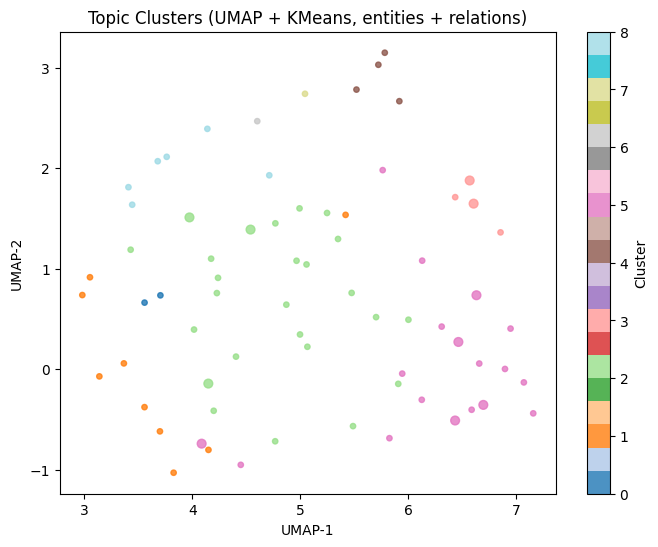

In [ ]:
plt.figure(figsize=(8, 6))
# Differentiate documents with a full relation triplet (curatable) by size
sizes = df_topics["has_relation"].map(lambda x: 40 if x else 15)

# Create the scatter plot using UMAP coordinates
scatter = plt.scatter(
    df_topics["umap_x"],
    df_topics["umap_y"],
    c=df_topics["cluster"],
    cmap="tab20", # Use a discrete colormap for clusters
    s=sizes,
    alpha=0.8
)

plt.title("Topic Clusters (UMAP + KMeans, entities + relations)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Cluster")
plt.show()

This bar chart visualizes the distribution of documents across the identified topics (clusters). This provides a quick overview of whether the clustering resulted in balanced groups or if some topics dominate the dataset.

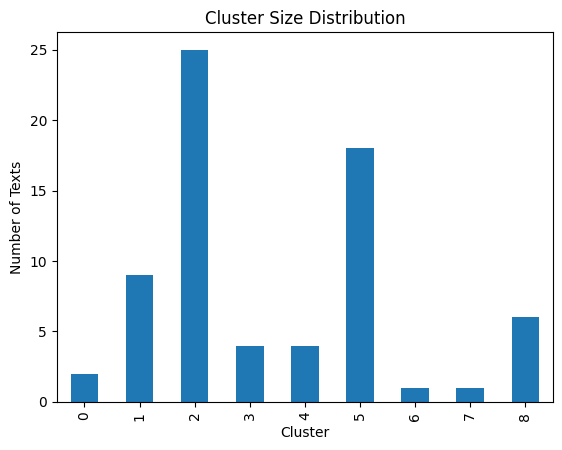

In [ ]:
df_topics["cluster"].value_counts().sort_index().plot(kind="bar")
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Texts")
plt.show()


This block generates a heatmap to visually profile each generated topic cluster based on the number of entities it contains.

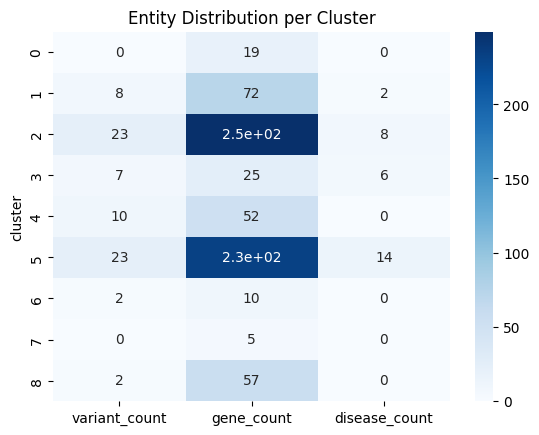

In [ ]:
import seaborn as sns
import numpy as np

heatmap_data = df_topics.groupby("cluster")[["variant_count", "gene_count", "disease_count"]].sum()

sns.heatmap(heatmap_data, annot=True, cmap="Blues")
plt.title("Entity Distribution per Cluster")
plt.show()
